## 0. Initialisation
### Requirements for this notebook
Preprocessed data frame containing: ['ts', 'trial_id', 'state_type', 'animal_id', 'heading_rel_flip', 'constant_distance', 'constant_speed']<br>
file type is currently pickle (.pkl) can be changed to hierarchical data format (HDF, .h5) if wanted
### Abbreviations:
- **DV:** distance / velocity (using heading_rel_flip)
- **RL:** right / left (using heading_rel)
- **PI:** preference index
### 0.1 Execute `move_files_to_subdirs_auto.sh` (subdirectory: "./LocustVR_data_analysis/") or `move_files_to_subdirs.sh`
- Import logged Locust VR Data
### 0.2 Run `data_exploration_tutorial.ipynb` 0.0-1.0
- Import temperature file (.txt)
### 0.3 Run `locustVR_data_preparation.ipynb` (subdirectory: "./LocustVR_data_analysis/")
- Annotation in google sheet:
    - url = f"https://docs.google.com/spreadsheets/d/{database_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
    - sheet_name = "Unity_MatrexVR" & database_id = "1UL4eEUrQMapx9xz11-IyOSlPBcep1I9vBJ2uGgVudb8"??


In [345]:
save_path = "/Users/jonny/Desktop/Uni/Master/collevtive behavior/VR_analysis"
# If saving of plots not intended comment line below
save_choice = True

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib

plt.style.use('default')

from LocustVR_data_analysis import utils_local
importlib.reload(utils_local)

# Adjust accordingly
data = pd.read_pickle(os.path.join(save_path, 'locustvr_data.pkl'))

## 1. Individual locusts preference throughout choices
- input:
    - **df**
        - **"animal_ID":** currently int from 0 to number of animals - 1 not animal ID string in google sheet
    - **time window:** start-end in seconds after start of choice phase
    - **threshold:** angle in degrees to determine choice
    - **RL:** using side preference additionally to feature preference
- preference determination:
    - metric: mean angle of heading during time window
    - rules:
        - if metric < -threshold [°]: choice = const_speed
        - elif metric \> threshold [°]: choice = const_size
        - else: neutral
- output:
    - **df_choice_phase:** df['choice_DV']: -1 (const_speed), 0 (neutral), 1 (const_size)
        - if RL=True df['choice_RL']: -1 (const_speed), 0 (neutral), 1 (const_size)

In [347]:
def trial_preferences(df, time_window=None, lower_threshold=45,upper_threshold=75, RL=False):
    if time_window is None:
        time_window = [6, 8]  # in s

    mask_time = df["ts"].between(time_window[0] * 100, time_window[1] * 100)
    df_choice_phase = df.loc[mask_time].copy()

    def compute_choice(metric, choice_col):
        df_choices = (
            df_choice_phase
            .groupby(["animal_id", "trial_id"])[metric]
            .mean()
            .reset_index()
        )

        for _, row in df_choices.iterrows():
            animal_id = row["animal_id"]
            trial_id = row["trial_id"]
            mean_heading_angle = row[metric]
        
            if np.radians(-upper_threshold) < mean_heading_angle < np.radians(-lower_threshold):
                choice = -1  # const_speed
            elif np.radians(upper_threshold) > mean_heading_angle > np.radians(lower_threshold):
                choice = 1   # const_size
            else:
                choice = 0   # neutral

            mask = (
                (df_choice_phase["animal_id"] == animal_id)
                & (df_choice_phase["trial_id"] == trial_id)
            )
            df_choice_phase.loc[mask, choice_col] = choice

    compute_choice(metric="heading_rel_flip", choice_col="choice_DV")

    if RL:
        compute_choice(metric="heading_rel", choice_col="choice_RL")

    return df_choice_phase

# test
# plt.scatter(df_choice_phase['mean_heading_angle'], df_choice_phase['choice'])

In [348]:

def trial_preferences_framewise(df, time_window=None, lower_threshold=45, upper_threshold=75, RL=False):
   
    if time_window is None:
        time_window = [6, 8]  # in s

    
    mask_time = df["ts"].between(time_window[0] * 100, time_window[1] * 100)
    df_choice_phase = df.loc[mask_time].copy()

    def compute_choice(metric, choice_col):
        angles = df_choice_phase[metric]

        
        neg_lower = np.radians(-upper_threshold)   
        neg_upper = np.radians(-lower_threshold)   
        pos_lower = np.radians(lower_threshold)    
        pos_upper = np.radians(upper_threshold) 

        cond_neg = (angles > neg_lower) & (angles < neg_upper)
        cond_pos = (angles > pos_lower) & (angles < pos_upper)

        df_choice_phase[choice_col] = 0

        df_choice_phase.loc[cond_neg, choice_col] = -1

        df_choice_phase.loc[cond_pos, choice_col] = 1

   
    compute_choice(metric="heading_rel_flip", choice_col="choice_DV")
    if RL:
        compute_choice(metric="heading_rel", choice_col="choice_RL")

    return df_choice_phase


### usage
- data frame
- time window [seconds] from start test phase
- threshold [°] of decision making (heading_rel_flip: +60° corresponds to constant distance option, -60° corresponds to constant speed option; heading_rel: +60° corresponds to left side, -60° corresponds to right side)

In [365]:
df_0 = data.copy()
df_0_sliced = df_0[df_0['animal_id']>= 36]
   
time_window_0 = [0,30]  # in s
low_threshold = 45
up_threshold = 75

df_choice = trial_preferences(df_0, time_window_0, low_threshold, up_threshold ,RL=True)
df_choice_framewise = trial_preferences_framewise(df_0_sliced, time_window_0, low_threshold, up_threshold ,RL=True)

### 2 plot animals choices
- input:
    - df: dataframe containing column ["choice_DV"]
    - animal ID
    - face color (options: [const_distance, const_speed])
    - save_fig (True/False)
- output:
    - scatter plot: y (choices [const_size, neutral, const_speed]) over x (trials)
    - color code:
        - face color: const_speed
        - edge color: const_distance
    - shape code:
        - state_type

In [350]:
def plot_individual_preferences(df, animal_id, face_color="constant_speed", save_fig = False):

    edge_color = 'constant_distance' if face_color == 'constant_speed' else 'constant_speed'

    mask_animal = df["animal_id"] == animal_id
    df_plot = df.loc[mask_animal].copy()

    # colormap viridis
    cmap = plt.cm.viridis
    color_map = {5: cmap(1.0), 3: cmap(0.5), 1: cmap(0.0),0: cmap(0.0)}
    color_map2 = {5: cmap(1.0), 10: cmap(0.5), 20: cmap(0.0),6: cmap(0.0)}

    # color red, orange, yellow
    # color_map = {5: 'red', 3: 'orange', 1: 'yellow'}
    # color_map2 = {5: 'red', 10: 'orange', 20: 'yellow'}

    marker_map = {1: 'o', 2: 's'}  # circle = 'o', square = 's'

    plt.figure(figsize=(10, 8))

    df_plot['color'] = df_plot[face_color].map(color_map)
    df_plot['edge_color'] = df_plot[edge_color].map(color_map2)
    df_plot['marker'] = df_plot['state_type'].map(marker_map)

    choice_map = {'const_speed': -1, 'neutral': 0, 'const_size': 1}

    for m, sub in df_plot.groupby('marker'):
        plt.scatter(sub['trial_id'], sub['choice_DV'],
                    color=sub['color'], marker=m,
                    edgecolor=sub['edge_color'], alpha=1, label=f'marker={m}', s=150, linewidths=2)
        plt.yticks(list(choice_map.values()), list(choice_map.keys()))

    plt.xlabel("Trial ID", fontsize=18)
    plt.ylabel("Choice", fontsize=18)
    plt.title(f"Animal {animal_id}", fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.tight_layout()

    if save_fig:
        plt.savefig(os.path.join(save_path, f'PI_trials_animal_{animal_id}.pdf'), format='pdf')
    plt.show()

### usage

In [ ]:
"""plot one animal"""
#animal_id_0 = 10

animal_ids = df_0['animal_id'].unique()

for animal_id in animal_ids:
    plot_individual_preferences(df_choice, animal_id, save_fig=save_choice)


"""plot every animal"""
# for animal_id in range(len(df_0['animal_id'].unique())):
#     plot_individual_preferences(df_choice, animal_id, face_color_0, save_fig=True, show_plot=save_choice)


### legend for individual trial choices plots

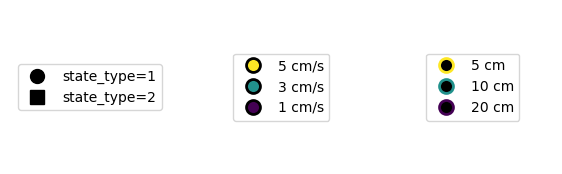

In [276]:
fig, ax = plt.subplots(1, 3, figsize=(7, 2))

cmap = plt.cm.viridis
color_map = {5: cmap(1.0), 3: cmap(0.5), 1: cmap(0.0)}
color_map2 = {5: cmap(1.0), 10: cmap(0.5), 20: cmap(0.0)}

marker_map = {1: 'o', 2: 's'}  # circle = 'o', square = 's'
# color_map = {5: 'red', 3: 'orange', 1: 'yellow'}
# color_map2 = {5: 'red', 10: 'orange', 20: 'yellow'}

mappings = [marker_map, color_map, color_map2]

import matplotlib.lines as mlines

for i, map in enumerate(mappings):
    for key, value in map.items():
        if i == 0:
            legend_element = mlines.Line2D([], [], color='black', marker=value, linestyle='None',
                                           markersize=10, label=f'state_type={key}')
        elif i == 1:
            legend_element = mlines.Line2D([], [], color=value, marker='o', linestyle='None',
                                           markersize=10, label=f'{key} cm/s', markeredgecolor='black',markeredgewidth=2)
        else:
            legend_element = mlines.Line2D([], [], color='black', marker='o', markeredgecolor=value,
                                           markeredgewidth=2, linestyle='None',
                                           markersize=10, label=f'{key} cm')
        ax[i].add_line(legend_element)
    ax[i].legend(loc='center')
    ax[i].axis('off')

if save_choice:
    plt.savefig(os.path.join(save_path, f'PI_trials_legend.pdf'), format='pdf')
plt.show()

## 3. preference across different starting distances
input: dataframe df containing column ["choice_DV", "choice_RL"]<br>
**Note:**<br>
- legend is manual, therefor style choices have to be adjusted in the plot and the legend
- due to amount of trials and discrete values of individual trials the PI might show discrete spacing and dots can overlap for that reason alpha<=1 was introduced

In [352]:
def preference_index(array):
    # preference index PI = (n_1 - n_-1) / (n_1 + n_0 + n_-1) = n_1 / (n_1 + n_0 + n_-1) - n_-1 / (n_1 + n_0 + n_-1)
    counts = array.value_counts(normalize=False)  # or normalize=True if you prefer
    n_pos = counts.get(1, 0)
    n_neg = counts.get(-1, 0)
    n_total = counts.sum()
    if n_total == 0:
        return np.nan
    return (n_pos - n_neg) / n_total

def preference_across_staring_dist(df, save_fig=False):
    fig, ax = plt.subplots(1, len(df['constant_distance'].unique()), figsize=(7, 4), sharey='all')
    # df_choice_plot = trial_preferences(df_0, time_window_0, threshold_0, RL=True)
    #df_choice_plot = df
    for i, dist in enumerate(df["constant_distance"].unique()):
        mask_dist = df["constant_distance"] == dist
        df_dist = df.loc[mask_dist].copy()

        cmap = plt.cm.viridis
        color_map_speed = {5: cmap(1.0), 3: cmap(0.5), 1: cmap(0.0), 0: cmap(0.5)}
        def half_sub_plot(df_dist, choice_col):
            plt.yticks(fontsize=16)

            if choice_col == "choice_DV":
                map_speed = {0: 1, 1: 2, 5: 3}
            else:
                map_speed = {0: 6, 1: 7, 5: 8}

            df_speed_animal = df_dist.groupby(["constant_speed" ,"animal_id"])[choice_col].apply(preference_index).reset_index()
            ax[i].set_title(f"Distance: {dist} cm", fontsize=16)
            for speed in df_speed_animal["constant_speed"].unique():
                mask_speed = df_speed_animal["constant_speed"] == speed
                df_speed = df_speed_animal.loc[mask_speed].copy()
                ax[i].scatter([map_speed[speed]]*len(df_speed), df_speed[choice_col], label=f"Speed {speed} cm/s", alpha=0.4, color=color_map_speed[speed])
                # median
                ax[i].plot([map_speed[speed]-0.45, map_speed[speed]+0.45], [np.median(df_speed[choice_col]), np.median(df_speed[choice_col])], color='black', linestyle='--', linewidth=0.8)
                # mean
                ax[i].plot([map_speed[speed]-0.45, map_speed[speed]+0.45], [np.mean(df_speed[choice_col]), np.mean(df_speed[choice_col])], color='gray', linestyle='-', linewidth=0.8)
                # std
                ax[i].plot([map_speed[speed]-0.3, map_speed[speed]+0.3], [np.mean(df_speed[choice_col]) + np.std(df_speed[choice_col]), np.mean(df_speed[choice_col]) + np.std(df_speed[choice_col])], color='gray', linestyle=':', linewidth=0.8)
                ax[i].plot([map_speed[speed]-0.3, map_speed[speed]+0.3], [np.mean(df_speed[choice_col]) - np.std(df_speed[choice_col]), np.mean(df_speed[choice_col]) - np.std(df_speed[choice_col])], color='gray', linestyle=':', linewidth=0.8)
            ax[i].set_xticks([1, 2, 3, 6, 7, 8], ['0', '1', '5', '0', '1', '5'], fontsize=16)
            ax[i].text(0, 1, "D")
            ax[i].text(0, -1, "V")
            ax[i].text(5, 1, "L")
            ax[i].text(5, -1, "R")
            ax[i].set_xlim(-0.5, 8.5)
            ax[i].set_ylim(-1.2, 1.2)

        half_sub_plot(df_dist, "choice_DV")
        half_sub_plot(df_dist, "choice_RL")

    plt.tight_layout()

    ax[0].set_ylabel("Preference Index", fontsize=16)
    fig.supxlabel("Agents Speed (cm/s)", fontsize=16, y=-0.04)

    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], color=cmap(0.), marker='o', linestyle='None'),
                    Line2D([0], [0], color=cmap(.5), marker='o', linestyle='None'),
                    Line2D([0], [0], color=cmap(1.), marker='o', linestyle='None'),
                    Line2D([0], [0], color="black", marker='None', linestyle='--'),
                    Line2D([0], [0], color="gray", marker='None', linestyle='-'),
                    Line2D([0], [0], color="gray", marker='None', linestyle='-'),
                    ]
    ax[-1].legend(custom_lines, ["0 cm/s", "1 cm/s", "5 cm/s", "median", "mean", "standard deviation"], bbox_to_anchor=(1.0, 1.04))
    if save_choice:
        plt.savefig(os.path.join(save_path, 'PI_animals_distances.pdf'),
                    format='pdf', bbox_inches='tight')
    plt.show()

### usage

KeyError: np.int64(3)

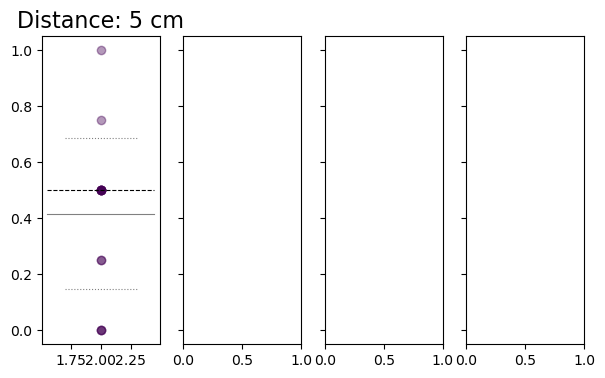

In [353]:
preference_across_staring_dist(df_choice, save_fig=save_choice)


In [354]:
def plot_PI_over_time(df,choice_col="choice_DV",bin_size_s=2):
    
    df = df.copy()

    df["time_s"] = df["ts"] / 100  
    df["time_bin"] = (df["time_s"] // bin_size_s).astype(int)
    df["time_bin_center"] = (df["time_bin"] + 0.5) * bin_size_s

    distances = sorted(df["constant_distance"].unique())
    speeds    = sorted(df["constant_speed"].unique())

   
    fig, ax = plt.subplots(
        len(distances),
        len(speeds),
        figsize=(4 * len(speeds), 3 * len(distances)),
        sharex=True,
        sharey=True
    )

    for i, dist in enumerate(distances):
        for j, speed in enumerate(speeds):
            mask = (df["constant_distance"] == dist) & (df["constant_speed"] == speed)
            df_sub = df.loc[mask].copy()

            pi_time = (
                df_sub
                .groupby(["animal_id", "time_bin_center"])[choice_col]
                .apply(preference_index)
                .reset_index()
            )
           
            for animal_id, group in pi_time.groupby("animal_id"):
                ax[i, j].plot(
                    group["time_bin_center"],
                    group[choice_col],
                    alpha=0.2
                )

            pi_stats = (
                pi_time
                .groupby("time_bin_center")[choice_col]
                .agg(["mean", "sem"])
                .reset_index()
            )

            ax[i, j].plot(
                pi_stats["time_bin_center"],
                pi_stats["mean"],
                linewidth=1.5,
                color="black"
            )

            ax[i, j].fill_between(
                pi_stats["time_bin_center"],
                pi_stats["mean"] - pi_stats["sem"],
                pi_stats["mean"] + pi_stats["sem"],
                alpha=0.2,
                color="black"
            )

            ax[i, j].axhline(0, linestyle="--", linewidth=0.8)

            ax[i, j].set_title(f"d = {dist} cm, v = {speed} cm/s", fontsize=10)

    fig.supxlabel("Time (s)", fontsize=12)
    fig.supylabel("Preference Index", fontsize=12)

    plt.tight_layout()

   

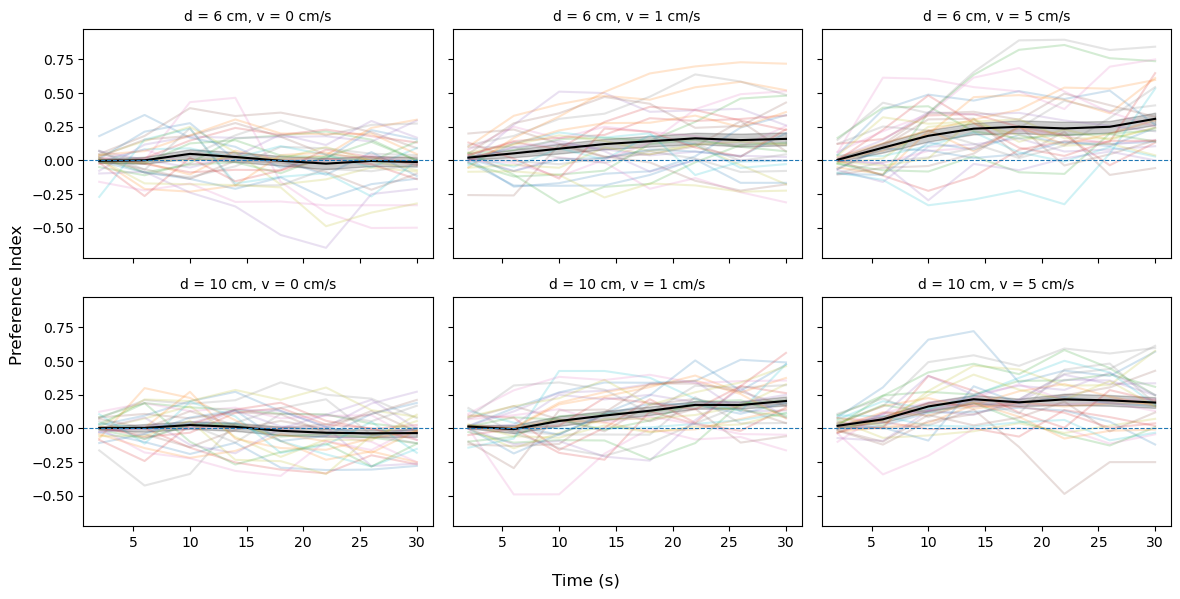

In [367]:
plot_PI_over_time(df_choice_framewise, choice_col="choice_DV",bin_size_s=4)

## 4 Orientation of individuals over time for different stimulation conditions
input: dataframe df containing column ["choice_DV", "choice_RL"]

In [357]:
# test
# print(df_0[mask_time].groupby(["constant_distance", "constant_speed"])["trial_id"].nunique())

def plot_angle_over_time(df, save_fig=save_choice):
    fig, ax = plt.subplots(len(df['constant_distance'].unique()), len(df['constant_speed'].unique()), figsize=(14, 9), sharey='row', sharex='col')
    mask_time = df["ts"].between(0, 3000)
    grouped = df[mask_time].groupby(
        ["constant_distance", "constant_speed", "animal_id", "trial_id"]
    )


    for i, dist in enumerate(sorted(df["constant_distance"].unique())):
        for j, speed in enumerate(sorted(df["constant_speed"].unique())):
            for (d, s, a, t), group in grouped:
                if d == dist and s == speed:
                    # ax[i, j].plot(group["ts"]/100, np.degrees(group["heading_rel_flip"]),
                    #               color='C1', linewidth=0.3, alpha=0.4)
                    ax[i, j].plot(group["ts"]/100, np.degrees(group["heading_rel_flip"].rolling(window=50, center=True).mean()),
                                  color='C1', linewidth=0.5, alpha=0.5)

            ax[i, j].hlines([60, -60], 0, 30, colors='gray', linestyles='--', linewidth=0.8)
            #ax[i, j].set_title(f"Distance: {dist}, Speed: {speed}", fontsize=12)
            if i == 0:
                ax[i, j].set_title(f"Speed: {speed} cm/s", fontsize=15)
            if i == 2:
                if j == 1:
                    ax[i, j].set_xlabel("time [s]", fontsize=15)

            if j == 0:
                if i == 1:
                    ax[i, j].set_ylabel(f"Distance: {dist} [cm]\nAngle [°]", fontsize=15)
                else:
                    ax[i, j].set_ylabel(f"Distance: {dist} [cm]\n", fontsize=15)
    plt.tight_layout()
    if save_choice:
        plt.savefig(os.path.join(save_path, f'orientation_test_phase_for_stimulus_conditions.png'), dpi=600)
    plt.show()

### usage

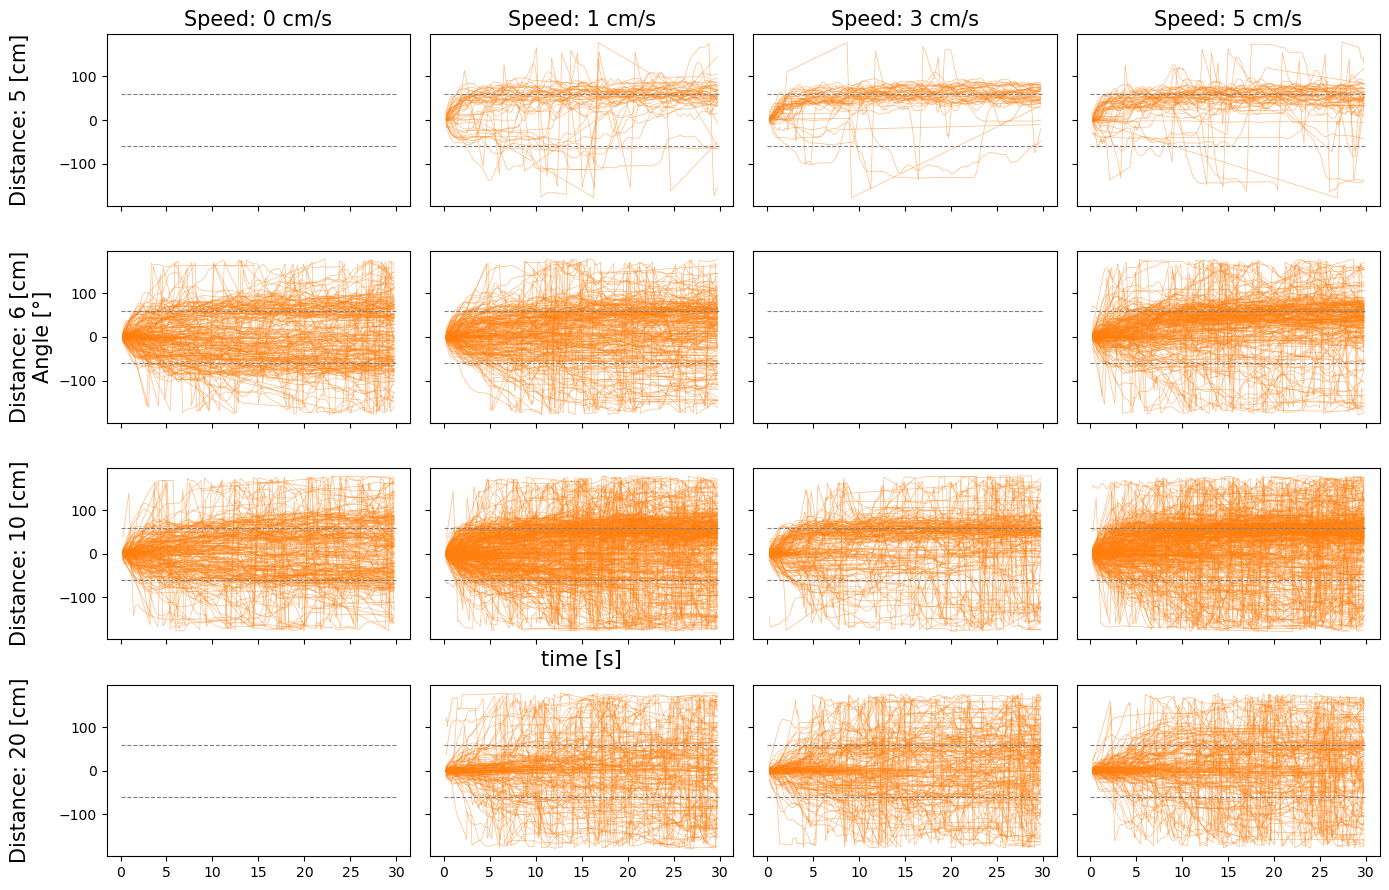

In [358]:
plot_angle_over_time(df_0, save_fig=save_choice)